# Training of the sentiment discriminator based on BERT and CNN

Discriminator 2: Model trained on the dataset, where all words are lowercased.

##Load libraries

In [1]:
! pip install transformers

In [2]:
import pandas as pd
import csv
import os
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from  transformers import BertTokenizer, TFBertForSequenceClassification,TFBertModel
from tensorflow.keras.utils import to_categorical
from transformers import BertConfig, BertModel
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot  as plt
from collections import defaultdict
import multiprocessing
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve,accuracy_score, recall_score, precision_score,f1_score
from sklearn.utils import shuffle

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read data class

Preparetion of data for training, validation and testing.

In [3]:
class ReadData:

    def __init__(self,path, X_col,y_col):

        self.path=path
        self.X_col=X_col
        self.y_col=y_col
        self.tar_cols=[X_col]+[y_col]
        self.data=self.open_file(self.path)
        self.X_train=pd.DataFrame()
        self.y_train=pd.DataFrame()
        self.X_val=pd.DataFrame()
        self.y_val=pd.DataFrame()
        self.X_test=pd.DataFrame()
        self.y_test=pd.DataFrame()
        self.X_train_resampled=pd.DataFrame()
        self.y_train_resampled=pd.DataFrame()


    def open_file(self,path):
        with open(path, 'r', newline='', encoding='utf-8') as f:
            dialect = csv.Sniffer().sniff(f.read(18192))
            f.seek(0)
            reader = csv.reader(f, dialect)
            header = next(reader)
            data = pd.DataFrame(reader,  columns=header)

        data=data[self.tar_cols]
        data = data[(data != '').all(axis=1)]
        data = shuffle(data,random_state=0)
       # data = data.sample(n=50000)
        return data

    def data_split(self):

        self.X_train, X_temp, self.y_train, y_temp = train_test_split(self.data[self.X_col],self.data[self.y_col],random_state=0,test_size=0.2, stratify=self.data[self.y_col])
        self.X_test, self.X_val, self.y_test, self.y_val = train_test_split(X_temp,y_temp,random_state=0,test_size=0.5, stratify=y_temp)
        return self.X_train, self.y_train,self.X_val, self.y_val,  self.X_test, self.y_test

    def resample_over(self, X, y):
        oversample = RandomOverSampler(sampling_strategy='minority',random_state=0)
        self.X_train_resampled, self.y_train_resampled = oversample.fit_resample(X.to_frame(), y.to_frame())
        return self.X_train_resampled.squeeze(), self.y_train_resampled.squeeze()

    def resample_under(self, X, y):
        undersample = RandomUnderSampler(sampling_strategy='majority',random_state=0)
        self.X_resampled, self.y_resampled = undersample.fit_resample(X.to_frame(), y.to_frame())
        shuffled_df = pd.concat([self.X_resampled, self.y_resampled], axis=1)
        shuffled_df = shuffled_df.sample(frac=1, random_state=42)
        self.X_resampled=shuffled_df[self.X_col]
        self.y_resampled=shuffled_df[self.y_col]
        return self.X_resampled.squeeze(), self.y_resampled.squeeze()


    def to_dataframe(self,X,y):
        return pd.concat([X, y], axis=1)




## Create class for sentiment classification model.

Setting up of architecture.

In [ ]:

class BERTSentimentCf:
    def __init__(self,model_name,num_labels):
        self.model_name=model_name
        self.num_labels=num_labels

    def tokenize_batch(self,X, max_length):
        tokenizer = BertTokenizer.from_pretrained(self.model_name)
        tokens_train = defaultdict(list)
        i=0
        for text in X:

          t = tokenizer(text.split(), is_split_into_words=True, padding='max_length', truncation=True, max_length=max_length)
          tokens_train['input_ids'].append(t['input_ids'])
          tokens_train['attention_mask'].append(t['attention_mask'])
          #tokens_train['labels'].append(lab)
          i=i+1

        input_ids = tf.stack(tokens_train['input_ids'])
        attention_mask = tf.stack(tokens_train['attention_mask'])
        return input_ids,attention_mask

    def tokenize(self,X,max_len):
        tokenizer = BertTokenizer.from_pretrained(self.model_name)
        X_tokenized = tokenizer(
        text=X.tolist(),
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True
        )

        return X_tokenized



    def create_model(self,dropout_rate,learning_rate,max_len):

       bert_model = TFBertModel.from_pretrained(self.model_name, self.num_labels)

       bert_model.trainable = False
       input_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
       input_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

       embeddings = bert_model(input_ids, attention_mask = input_mask)[0] # 0 = last hidden state, 1 = poller_output
       out = tf.keras.layers.Conv1D(filters=50,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")(embeddings)
       out = tf.keras.layers.Conv1D(filters=50,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")(out)

       out=tf.keras.layers.GlobalMaxPool1D()(out)
       out = tf.keras.layers.Dense(256, activation='relu',kernel_initializer='he_normal')(out)
       out = tf.keras.layers.Dropout(0.2)(out)
       y = tf.keras.layers.Dense(self.num_labels, activation=None ,kernel_initializer='glorot_uniform')(out)
       model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)

       lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=10000,
        decay_rate=0.9)
       optimizer = tf.keras.optimizers.Adam(
           learning_rate=learning_rate,
           clipvalue=1.0
       )

       loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
       metric_accuracy = tf.keras.metrics.CategoricalAccuracy('categorical_accuracy')
       metric_precision = tf.keras.metrics.Precision()
       metric_recall = tf.keras.metrics.Recall()

       model.compile(
           optimizer=optimizer,
           loss=loss,
           metrics=[metric_accuracy,metric_precision,metric_recall]
       )
       return model

## Train the model

### Read data, split and create model

In [4]:
read_data=ReadData("/content/drive/MyDrive/Masterthesis/Data/data_processed/preprocessed50000_lower.tsv","preprocessed_text","sentiment")
X_train, y_train,X_val, y_val,  X_test, y_test = read_data.data_split()
X_under, y_under=read_data.resample_under(X_train, y_train)
df_test=read_data.to_dataframe(X_test, y_test)
df_val=read_data.to_dataframe(X_val, y_val)
df_under=read_data.to_dataframe(X_under, y_under)


In [ ]:
model_name = 'dbmdz/bert-base-german-cased'

train_size=len(y_train)
batch_size=32
max_length=228
dropout_rate=.1
learning_rate=1e-04


Bert=BERTSentimentCf(model_name,2)
model=Bert.create_model(dropout_rate, learning_rate, max_length)




config.json:   0%|          | 0.00/456 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
train_input_ids,train_attention_mask=Bert.tokenize_batch(X_train,max_length)
test_input_ids,test_attention_mask=Bert.tokenize_batch(X_test,max_length)
val_input_ids,val_attention_mask=Bert.tokenize_batch(X_under,max_length)

tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

In [ ]:
#from tensorflow.keras.callbacks import ReduceLROnPlateau
early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=6,
            restore_best_weights=True
)

num_threads = multiprocessing.cpu_count()
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)


### Train the model

In [ ]:
history = model.fit(
    x={'input_ids': train_input_ids, 'attention_mask': train_attention_mask},
    y=to_categorical(y_under),
    validation_data=({'input_ids': val_input_ids, 'attention_mask': val_attention_mask},  to_categorical(y_val)),
    epochs=25,
    batch_size=128,
    callbacks=[early_stopping],
    workers=num_threads,
    use_multiprocessing=True#,

)


Epoch 1/25
59/59 [==============================] - 236s 4s/step - loss: 0.7901 - categorical_accuracy: 0.5341 - precision: 0.5229 - recall: 0.5175 - val_loss: 0.5491 - val_categorical_accuracy: 0.7732 - val_precision: 0.7114 - val_recall: 0.7312
Epoch 2/25
59/59 [==============================] - 210s 4s/step - loss: 0.6059 - categorical_accuracy: 0.6698 - precision: 0.6297 - recall: 0.6045 - val_loss: 0.4311 - val_categorical_accuracy: 0.8142 - val_precision: 0.7993 - val_recall: 0.7838
Epoch 3/25
59/59 [==============================] - 209s 4s/step - loss: 0.4895 - categorical_accuracy: 0.7717 - precision: 0.7320 - recall: 0.6850 - val_loss: 0.3492 - val_categorical_accuracy: 0.8400 - val_precision: 0.8278 - val_recall: 0.8394
Epoch 4/25
59/59 [==============================] - 209s 4s/step - loss: 0.4282 - categorical_accuracy: 0.8094 - precision: 0.7701 - recall: 0.7738 - val_loss: 0.3501 - val_categorical_accuracy: 0.8386 - val_precision: 0.8148 - val_recall: 0.8550
Epoch 5/25
5

In [ ]:
model.save("/content/drive/MyDrive/Masterthesis/Models/sentiminator_disc_25epochs_lowercased_with_stopwords_and_punctuation.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Test Model

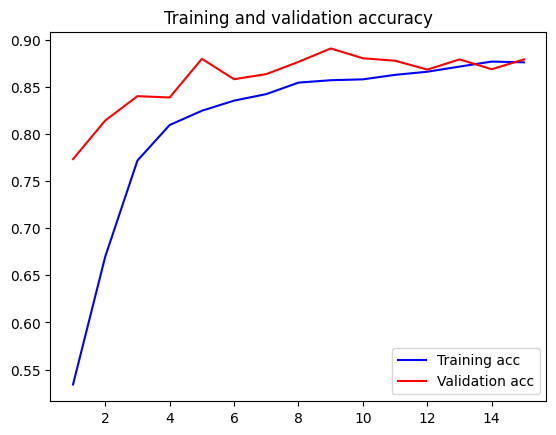

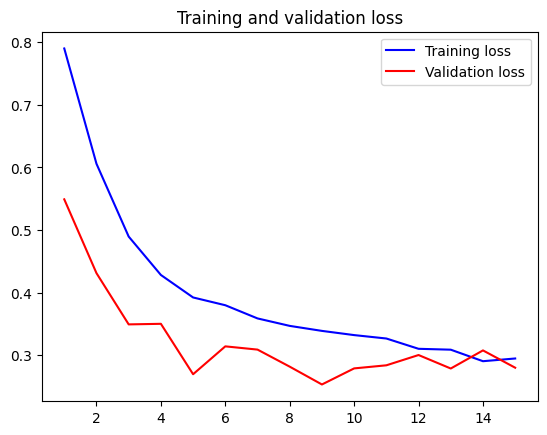

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model.save_weights('checkpoints_all/temp1')

In [5]:
model2=tf.keras.models.load_model("/content/drive/MyDrive/Masterthesis/Models/sentiminator_disc_25epochs_lowercased_with_stopwords_and_punctuation.h5",custom_objects={"TFBertModel": TFBertModel})


In [ ]:
model2=tf.keras.models.load_model("/content/drive/MyDrive/Masterthesis/Models/sentiminator_disc_25epochs_lowercased_with_stopwords_and_punctuation.h5",custom_objects={"TFBertModel": TFBertModel})

# Evaluate the model
val_evaluation_data = {
    'input_ids': val_input_ids,
    'attention_mask': val_attention_mask
}
evaluation = model2.evaluate(val_evaluation_data ,to_categorical(y_val))
print("Val Evaluation results:", evaluation)

train_evaluation_data = {
    'input_ids': train_input_ids,
    'attention_mask': train_attention_mask
}
evaluation = model2.evaluate(train_evaluation_data ,to_categorical(y_under))
print("train Evaluation results:", evaluation)


test_evaluation_data = {
    'input_ids': test_input_ids,
    'attention_mask': test_attention_mask
}
evaluation = model2.evaluate(test_evaluation_data ,to_categorical(y_test))
print("Test Evaluation results:", evaluation)

157/157 [==============================] - 91s 519ms/step - loss: 0.2780 - categorical_accuracy: 0.8790 - precision: 0.9424 - recall: 0.7264
Val Evaluation results: [0.27800145745277405, 0.8790000081062317, 0.9423975348472595, 0.7264000177383423]
236/236 [==============================] - 128s 541ms/step - loss: 0.3145 - categorical_accuracy: 0.8702 - precision: 0.9338 - recall: 0.6760
train Evaluation results: [0.31452515721321106, 0.8701884746551514, 0.9338100552558899, 0.6760021448135376]
157/157 [==============================] - 85s 539ms/step - loss: 0.2777 - categorical_accuracy: 0.8810 - precision: 0.9470 - recall: 0.7358
Test Evaluation results: [0.27765271067619324, 0.8809999823570251, 0.9469755291938782, 0.73580002784729]


157/157 [==============================] - 84s 536ms/step


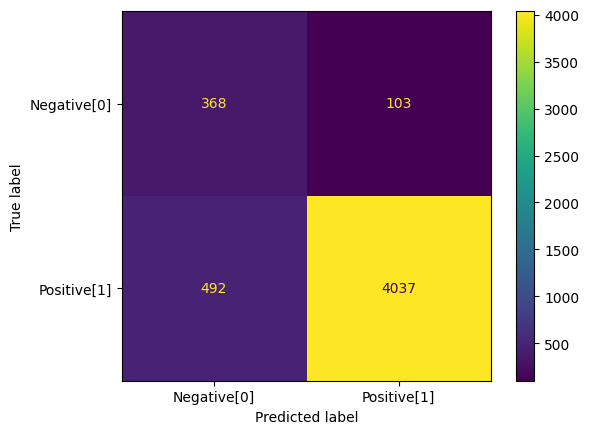

Accuracy: 0.881
Recall: 0.8913667476264076
Precision: 0.97512077294686
F1-score: 0.9313646325989158


In [ ]:
predicted_test = model2.predict({'input_ids': test_input_ids, 'attention_mask':test_attention_mask })
probabilities_test = tf.nn.softmax(predicted_test)
y_predicted = np.argmax(probabilities_test,axis=1)


cm=confusion_matrix(y_test.astype(int).to_list(), y_predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Negative[0]", "Positive[1]"])

cm_display.plot()
plt.show()

accuracy = accuracy_score(y_test.astype(int).to_list(), y_predicted)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test.astype(int).to_list(), y_predicted)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test.astype(int).to_list(), y_predicted)
print("Precision:", precision)

f1 = f1_score(y_test.astype(int).to_list(), y_predicted)
print("F1-score:", f1)
